In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/Projects/ArSLR/datasets \content1

# **Loading the Dataset**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/content1/ArASL_Database'

datagen = ImageDataGenerator(rescale=1./255)

data_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical'
)
folder_classes = data_generator.class_indices
print("Class Labels:", folder_classes)

Found 43421 images belonging to 32 classes.
Class Labels: {'ain': 0, 'al': 1, 'aleff': 2, 'bb': 3, 'dal': 4, 'dha': 5, 'dhad': 6, 'fa': 7, 'gaaf': 8, 'ghain': 9, 'ha': 10, 'haa': 11, 'jeem': 12, 'kaaf': 13, 'khaa': 14, 'la': 15, 'laam': 16, 'meem': 17, 'nun': 18, 'ra': 19, 'saad': 20, 'seen': 21, 'sheen': 22, 'ta': 23, 'taa': 24, 'thaa': 25, 'thal': 26, 'toot': 27, 'waw': 28, 'ya': 29, 'yaa': 30, 'zay': 31}


# **Split data into training , Test, Validation**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = '/content/content1/ArASL_Database'
test_dir = '/content/content1/Test_Database'


# Training data generator
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.1)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 39093 images belonging to 32 classes.
Found 4328 images belonging to 32 classes.
Found 10838 images belonging to 32 classes.


# **Build the CNN+Transformer Model**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D)
import tensorflow as tf

def create_cnn_transformer_model(input_shape=(64, 64, 3), num_classes=32, num_heads=8, transformer_units=128):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    shape_before_flatten = tf.keras.backend.int_shape(x)
    x = Reshape((-1, shape_before_flatten[-1]))(x)

    positional_encoding = tf.keras.layers.Embedding(
        input_dim=shape_before_flatten[1] * shape_before_flatten[2],
        output_dim=shape_before_flatten[-1],
    )(tf.range(shape_before_flatten[1] * shape_before_flatten[2]))
    x = x + positional_encoding

    keydim = shape_before_flatten[-1] // num_heads
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=keydim)(x, x)
    attention_output = Add()([x, attention_output])

    x = LayerNormalization()(attention_output)

    feedforward = Dense(transformer_units, activation='relu')(x)
    feedforward = Dense(shape_before_flatten[-1])(feedforward)
    x = Add()([x, feedforward])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# Compile the model
model = create_cnn_transformer_model(input_shape=(64, 64, 3), num_classes=32)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 128)        │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 128)        │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 128)        │         66,048 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 128)        │              0 │ add[0][0],             │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 128)        │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 128)        │         16,512 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 128)        │         16,512 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 128)        │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 128)        │            256 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 326,944 (1.25 MB)

 Trainable params: 326,944 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define the checkpoint callback before training

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Projects/ArSLR/checkpoint/best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [7]:
#train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=64,
    validation_steps=64,

    callbacks=[checkpoint]
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.0324 - loss: 3.9834
Epoch 1: val_loss improved from inf to 3.50866, saving model to /content/drive/MyDrive/Projects/ArSLR/checkpoint/best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.0324 - loss: 3.9820 - val_accuracy: 0.0293 - val_loss: 3.5087
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.0274 - loss: 3.7651
Epoch 2: val_loss did not improve from 3.50866
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.0275 - loss: 3.7644 - val_accuracy: 0.0312 - val_loss: 3.5250
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.0334 - loss: 3.6959
Epoch 3: val_loss did not improve from 3.50866
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 866ms/step - accuracy: 0.0335 - loss: 3.6953 - val_accuracy: 0.0216 - val_loss: 3.5186
Epoch 4/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.0348 - loss: 3.6458
Epoch 4: val_loss improved from 3.50866 to 3.47754, saving model to /content/drive/MyDrive/Projects/ArSLR/checkpoint/best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0348 - loss: 3.6455 - val_accuracy: 0.0386 - val_loss: 3.4775
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.0318 - loss: 3.6028
Epoch 5: val_loss improved from 3.47754 to 3.47211, saving model to /content/drive/MyDrive/Projects/ArSLR/checkpoint/best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.0319 - loss: 3.6028 - val_accuracy: 0.0342 - val_loss: 3.4721
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.0295 - loss: 3.5447
Epoch 6: val_loss improved from 3.47211 to 3.39499, saving model to /content/drive/MyDrive/Projects/ArSLR/checkpoint/best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 913ms/step - accuracy: 0.0296 - loss: 3.5443 - val_accuracy: 0.0302 - val_loss: 3.3950
E

In [8]:
# Evaluate the model (on validation data)
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy* 100:.2f}%")

136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - accuracy: 0.8590 - loss: 0.5283
Validation Loss: 0.5102933645248413
Validation Accuracy: 86.30%


In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


339/339 ━━━━━━━━━━━━━━━━━━━━ 88s 259ms/step - accuracy: 0.9439 - loss: 0.1983
Test Accuracy: 94.69%


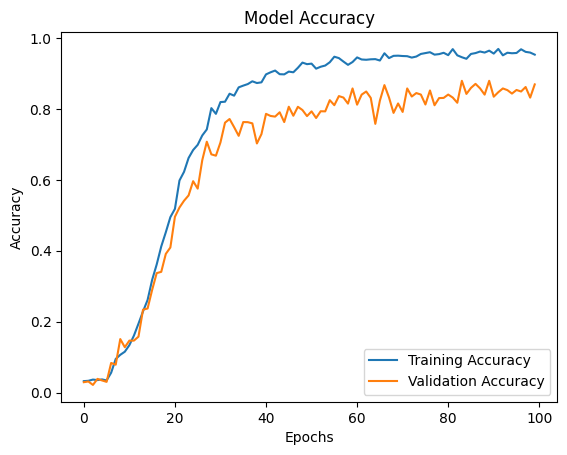

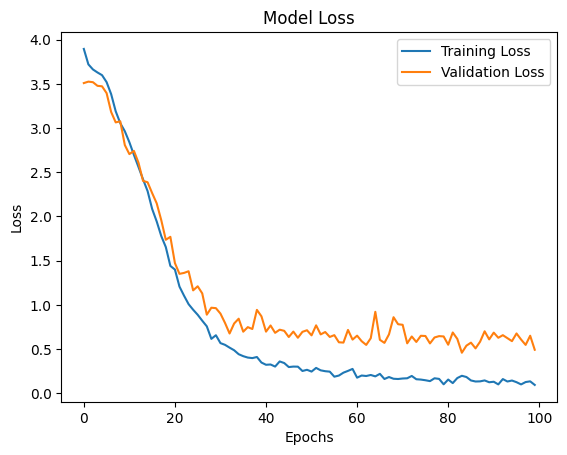

In [10]:
#visualize Training Results
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import classification_report

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


339/339 ━━━━━━━━━━━━━━━━━━━━ 92s 270ms/step
              precision    recall  f1-score   support

         ain       0.97      0.97      0.97       424
          al       0.97      0.97      0.97       268
       aleff       0.91      0.94      0.93       334
          bb       1.00      0.90      0.95       362
         dal       0.96      0.87      0.91       326
         dha       0.87      0.98      0.92       348
        dhad       0.97      0.97      0.97       336
          fa       0.95      0.90      0.93       391
        gaaf       0.91      0.91      0.91       342
       ghain       1.00      0.93      0.96       417
          ha       0.93      0.93      0.93       318
         haa       0.89      0.95      0.92       305
        jeem       0.91      0.96      0.93       314
        kaaf       0.93      0.95      0.94       354
        khaa       0.92      0.88      0.90       321
          la       0.97      0.94      0.96       351
        laam       0.97      0.99    

In [ ]:
# Save the model
model.save('/content/content/MODEL/ar_sign_language_model.keras')
